In [125]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import datetime
from graphviz import Digraph
import time
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import tabulate

In [124]:
sns.set(rc={'figure.figsize':(12.7,10.27)})

In [123]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.2f}'.format

In [289]:
# Загрузка данных
df = pd.read_csv('/Users/kost/Desktop/решено/data/statistics-07-20.csv',sep=';',parse_dates=['operation_date'])
new_data = pd.read_csv('/Users/kost/Desktop/решено/data/ssp_stat_load_car-94-96.csv',sep=';',parse_dates=['operation_date'])
train_ops = pd.read_csv('/Users/kost/Desktop/решено/data/poezd.csv', sep=';', encoding='utf-8')
car_ops = pd.read_csv('/Users/kost/Desktop/решено/data/codes.csv',sep=';', encoding='utf-8')
edf = pd.read_csv('RZD.csv', sep='\t', encoding='utf-8')

In [370]:
# Датасет отсортированный по станции > номеру вагона > времени операции
# ndf = df.sort_values(by=['operation_st_id','car_number','operation_date']).drop_duplicates().reset_index(drop=True)

# Датасет из свежих данных от 21/05/21
ndf = new_data.copy()

In [390]:
ndf.car_number.value_counts()[ndf.car_number.value_counts() < 50]

67062638    49
50655810    49
56179765    49
68094440    49
52485075    49
            ..
64331861     1
73986259     1
62736335     1
50604644     1
55338917     1
Name: car_number, Length: 117584, dtype: int64

In [372]:
ndf.operation_st_esr.value_counts()[ndf.operation_st_esr.value_counts() < 500]

942603    477
941009    450
966006    444
950606    417
968500    380
951208    352
965906    301
967704    300
942904    263
964301    260
967403    248
960601    242
965304    202
953102    188
950718    180
963101    169
951602    148
951104    148
967009    146
962908    119
943305    116
954206    110
943714     78
941403     73
962503     65
953006     57
954308     47
962005     44
941206     36
954901     27
966203     25
951405     24
966400     18
944628     16
947503     12
956313     12
948474     11
952605      6
953222      6
950506      4
957045      1
Name: operation_st_esr, dtype: int64

### Переменные:

In [421]:
"""
Примеры номеров станций ['operation_st_esr']
"""
# st_id = 889505 # 100 ops, 4 cars
# st_id = 845009 # 90 ops, 28 cars
# st_id = 977000 # 50 ops, 10 cars
# st_id = 985906 # 207037 ops, 43702 cars
# st_id = 925701 # 37386 ops, 3801 cars
# st_id = 926206 # 18489 ops, 363 cars
# st_id = 880407
# st_id = 967704 ## << wtf??
# st_id = 881804
# st_id = 986103 ## Top destination 
# st_id = 863007 ## 5th by destination
st_id = 950101

"""
Примеры номеров вагонов ['car_number']
"""
# car_num = 55864821 # вагон с максимальным количеством операций 310
# car_num = 94033792
# car_num = 62324355
# car_num = 37843901
# car_num = 61810677
# car_num = 37812401
# car_num = 37695855
# car_num = 30849038
# car_num = 63852057
# car_num = 42051045
# car_num = 44591014
# car_num = 55864821
# car_num = 62236872
# car_num = 30860712
# car_num = 30870752
# car_num = 42051359
# car_num = 42780155
# car_num = 30061394
# car_num = 55952550
car_num = 67062638 ## good graph

"""
Примеры номеров поездов ['index_train']
"""
train_num = 925701004926206

#######################

# переменная для построения графов
carSet = {car_num}


# проверка соответствия st_id и car_num
def check_st_car(st_id, car_num):
    if ndf.operation_st_esr[ndf.car_number == car_num][ndf.operation_st_esr == st_id].shape[0] == 0:
        print(f'Для станции {st_id} нет записей с вагоном {car_num}')
        print(f'\nТоп 10 вагонов по количеству записей для станции:\n')
        print(
            pd.DataFrame(
                {'Вагон': ndf.car_number[ndf.operation_st_esr == st_id].value_counts().index[:10],
                 'Строк': ndf.car_number[ndf.operation_st_esr == st_id].value_counts().values[:10]}
            )

        )
        print(f'\nС вагоном {car_num} есть записи на следующих станциях:\n')
        print(
            pd.DataFrame(
                {'Станция': ndf.operation_st_esr[ndf.car_number == car_num].value_counts().index,
                 'Строк': ndf.operation_st_esr[ndf.car_number == car_num].value_counts().values}
            )
        )

    else:
        print(
            f'Для станции {st_id} есть \
{ndf.operation_st_esr[ndf.car_number == car_num][ndf.operation_st_esr == st_id].shape[0]} \
строк(а) по вагону {car_num}'
        )


check_st_car(st_id, car_num)
print(f'\nВагон {car_num} также присутствует в записях со следующими поездами: \n\n\
{ndf.index_train[ndf.car_number == car_num].value_counts()}')


Для станции 950101 есть 24 строк(а) по вагону 67062638

Вагон 67062638 также присутствует в записях со следующими поездами: 

956305498950101.00    4
961407474950101.00    4
950101861956305.00    3
950101863956305.00    3
950101857956305.00    3
950101309951706.00    2
970001524950101.00    2
956305504950101.00    2
950101301951706.00    1
Name: index_train, dtype: int64


In [374]:
def extract_train(index_train):
    lst = []
    for i,j in enumerate(str(index_train)):
        lst.append(j)
        i+=1
    print('Единая Сетевая Разметка, ЕСР:', ''.join(lst[0:6]))
    print('Порядковый номер состава:', ''.join(lst[6:9]))
    print('ЕСР железнодорожной станции назначения поезда:', ''.join(lst[9:16]))

In [375]:
def extract_car(car_number):
    lst = []
    for i,j in enumerate(str(car_number)):
        if i == 0 and j == '2':
            lst.append('крытый')
        elif i == 0 and j == '3':
            lst.append('специальный вагон (к примеру, четырехосный думпкар, хоппер-дозатор, транспортер)')
        elif i == 0 and j == '4':
            lst.append('платформы')
        elif i == 0 and j == '5':
            lst.append('означает, что вагон отнесен к группе собственных грузовых вагонов и не входит в состав парка ОАО «РЖД»')
        elif i == 0 and j == '6':
            lst.append('полувагон')
        elif i == 0 and j == '7':
            lst.append('цистерны')
        elif i == 0 and j == '8':
            lst.append('изотермические')
        elif i == 0 and j == '9':
            lst.append('прочие')
        elif i == 1 and j == '2':
            lst.append('двух осный')
        elif i == 1 and j == '4':
            lst.append('четырех осный')
        elif i == 1 and j == '6':
            lst.append('шести осный')
        elif i == 1 and j == '8':
            lst.append('восьми осный')
        elif i == 1 and j == '12':
            lst.append('двенадцати осный')
        elif i == 1 and j == '16':
            lst.append('шестнадцати осный')
        elif i == 2 and j == '5':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '6':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '7':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '8':
            lst.append('цистерна с объемом котла 75 м3')
        elif i == 2 and j == '9':
            lst.append('цистерна с объемом котла 85,6 м3')
        elif i == 3 and j.isdigit():
            lst.append('номер вагона который был присвоен заводом: {}'.format(j))
        elif i == 4 and j.isdigit():
            lst.append(j)
        elif i == 5 and j.isdigit():
            lst.append(j)
        elif i == 6 and j.isdigit():
            lst.append('имеется ручной тормоз или переходная площадка, код: {}'.format(j))
        elif i == 7 and j.isdigit():
            lst.append('контрольная число вагона: {}'.format(j))
        else:
            continue
    return lst

In [362]:
extract_train(train_num)

Единая Сетевая Разметка, ЕСР: 925701
Порядковый номер состава: 004
ЕСР железнодорожной станции назначения поезда: 926206


In [363]:
extract_car(car_num)

['специальный вагон (к примеру, четырехосный думпкар, хоппер-дозатор, транспортер)',
 'цистерна с объемом котла 75 м3',
 'номер вагона который был присвоен заводом: 8',
 '7',
 '3',
 'имеется ручной тормоз или переходная площадка, код: 0',
 'контрольная число вагона: 1']

### Избавление от пропусков

#### Операции с поездом когда нет данных по операции с вагоном:

In [70]:
for i in ndf.operation_train[ndf.operation_car.isna()].value_counts().index:
    print(i,train_ops.description[train_ops.index_code == i].values)

In [40]:
# все пропуски можно заменить операцией отправления
ndf.operation_car = ndf.operation_car.fillna(2)

#### Предполагаем что если опасность вагона не указана, значит она отсутствует:

In [71]:
ndf.danger = ndf.danger.fillna(0)

### Первичный анализ датасета

In [296]:
df.columns

Index(['index_train', 'length', 'car_number', 'destination_esr', 'adm',
       'danger', 'gruz', 'loaded', 'operation_car', 'operation_date',
       'operation_st_esr', 'operation_st_id', 'operation_train', 'receiver',
       'rodvag', 'rod_train', 'sender', 'ssp_station_esr', 'ssp_station_id',
       'tare_weight', 'weight_brutto'],
      dtype='object')

In [294]:
new_data.columns

Index(['adm', 'car_number', 'danger', 'destination_esr', 'destination_id',
       'group_car', 'gruz', 'id', 'index_train', 'innovag', 'int_disl', 'kds',
       'kod_group', 'length', 'loaded', 'lves', 'number_train',
       'ont_time_write', 'operation_car', 'operation_date', 'operation_st_esr',
       'operation_st_id', 'operation_train', 'operator', 'park', 'receiver',
       'rodvag', 'rod_train', 'sender', 'ssp_station_esr', 'ssp_station_id',
       'stkgos_id', 'tare_weight', 'track', 'train_id', 'uns', 'weight',
       'weight_brutto', 'weight_netto', 'following_mark', 'processing_road',
       'junction', 'special_mark_1', 'dispatch_id'],
      dtype='object')

<AxesSubplot:>

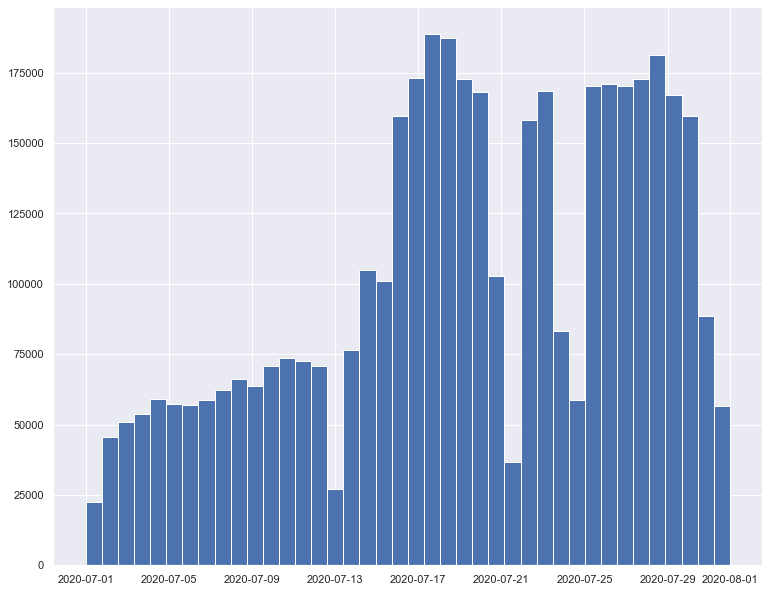

In [131]:
df.operation_date.hist(bins=40)

<AxesSubplot:>

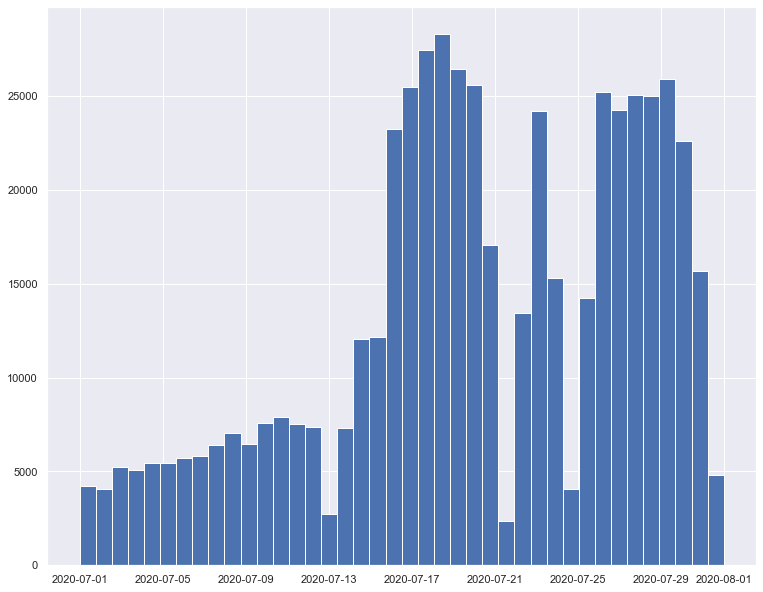

In [224]:
df.operation_date[df.operation_car.isna()].hist(bins=40)

<AxesSubplot:>

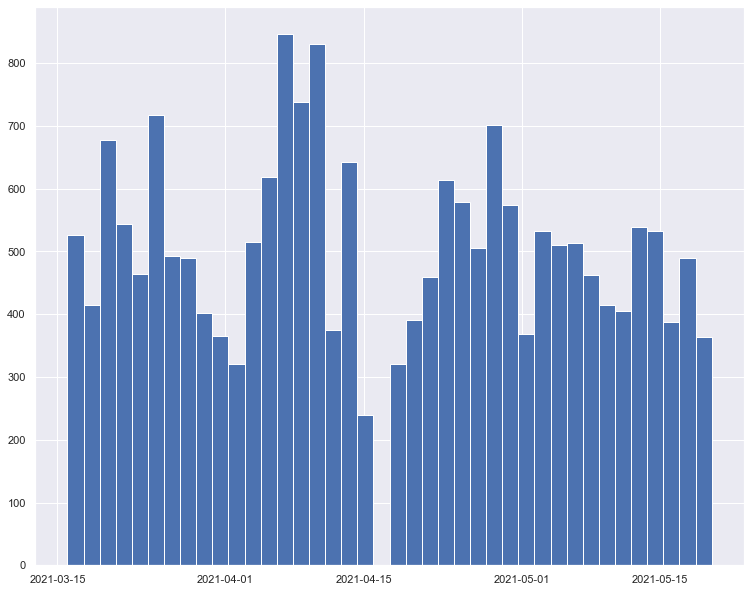

In [393]:
ndf.operation_date[ndf.operation_st_esr == st_id].hist(bins=40)

In [394]:
print(f'Размерность датасета: {ndf.shape}\n')
print(f'Временной диапазон:\nmin: {ndf.operation_date.min()}\nmax: {ndf.operation_date.max()}\n')

print(f'Уникальных станций: {ndf.operation_st_id.nunique()}')
print(f'Уникальных вагонов: {ndf.car_number.nunique()}\n')

print(f'Количество вагонов которые были отправлены хотя бы один раз:\
 {ndf.car_number[ndf.operation_car == 2].nunique()}')
print(f'В датасете нет данных об отправке\
 {ndf.car_number.nunique() - ndf.car_number[ndf.operation_car == 2].nunique()} уникальных вагонов\n')

# print('Количество операций с вагонами без станции:')
# ol = []
# for op in list(ndf.operation_car[ndf.operation_st_id.isna()].value_counts().index):
#     ol.append(car_ops[car_ops.index_code == op].values[0][1]) 

# print(pd.DataFrame(
#     {'Шифр': ol,
#      'Опер.': ndf.operation_car[ndf.operation_st_id.isna()].value_counts().index,
#      'Строк': ndf.operation_car[ndf.operation_st_id.isna()].value_counts().values
#     }))

Размерность датасета: (1501134, 44)

Временной диапазон:
min: 2021-03-16 00:01:00
max: 2021-05-20 05:51:00

Уникальных станций: 141
Уникальных вагонов: 119768

Количество вагонов которые были отправлены хотя бы один раз: 95585
В датасете нет данных об отправке 24183 уникальных вагонов



In [348]:
print('Уникальных операций с вагонами в датасете:')
for i in ndf.operation_car[ndf.operation_car.notnull()].value_counts().index:
    print(i,car_ops.description[car_ops.index_code == i].values)

Уникальных операций с вагонами в датасете:
4 ['ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
3 ['ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
81 ['УБОРКА ВАГОНА С ПП                    ']
80 [' ПОДАЧА ВАГОНА НА ПП                  ']
2 ['ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']
21 ['ВЫГРУЗКА НА ПП                        ']
8 ['ПРИБЫТИЕ ВАГОНА НА СТАНЦИЮ            ']
19 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']
11 ['ПОГРУЗКА НА ПП                        ']
18 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
79 [' ПРОЧИЕ УБОРКИ ВАГОНА ГУ-45М          ']
78 [' ПРОЧИЕ ПОДАЧИ ВАГОНА ГУ-45М          ']
20 ['ВЫГРУЗКА НА МЕСТАХ ОБЩ. ПОЛЬЗОВАНИЯ   ']
10 ['ПОГРУЗКА НА МЕСТАХ ОБЩ.ПОЛЬЗОВАНИЯ    ']
30 ['ЗАНЯТИЕ ПРИ СОРТ. МЕЛКИХ ОТП. И КОНТ. ']
28 ['ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
40 ['ОСВОБ. ПРИ СОРТ.МЕЛК.ОТПРАВОК И КОНТ. ']
29 ['ПРОЧИЕ, УЧИТЫВАЕМЫЕ КАК ВЫГРУЗКА      ']


In [349]:
print('Уникальных операций с поездами в датасете:')
for i in ndf.operation_train[ndf.operation_train.notnull()].value_counts().index:
    print(i,train_ops.description[train_ops.index_code == i].values)

Уникальных операций с поездами в датасете:
5.0 ['Окончание формирования поезда']
4.0 ['Расформирование поезда']
2.0 ['Отпр. поезда со станции (без сдачи на дорогу,отделение,участок ДНЦ)']
1.0 ['Приб. поезда на станцию (без приема на дорогу, отделение, участок ДНЦ)']
72.0 ['Отцепка вагонов']
71.0 ['Прицепка вагонов']
51.0 ['Приб. поезда на станцию с приемом на участок ДНЦ']
62.0 ['Отпр. поезда со станции со сдачей на соседний участок']
44.0 ['Подача маршрута под грузовые операции']
30.0 ['Отпр. (просл.) поезда со станции "чужой" дороги в направл. "нашей" дороги']
22.0 ['Отпр. поезда co станции со сдачей на другую дорогу']
11.0 ['Приб. поезда с приемом на дорогу, из-за границы или новостройки']
35.0 ['Образование соединенного поезда']


#### Справочные инструменты:

In [350]:
# по номеру операции вывести описание из справочников по вагонами и поездам
def get_op_info(operation_code):
    try:
        v = f'По вагону: {car_ops[car_ops.index_code == operation_code].values[0]}'
    except:
        v = 'NOP'
    try:
        p = f'По поезду: {train_ops[train_ops.index_code == operation_code].values[0]}'
    except:
        p = 'NOP'
    
    return [v,p]
    
get_op_info(3)

["По вагону: [3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']",
 "По поезду: [3 'Пс' 'Просл. поездом станции без остановки (без приема/сдачи)']"]

In [377]:
# Выборка станций по количеству записей для станции в датасете:
df.operation_st_esr.value_counts()[df.operation_st_esr.value_counts() < 400]

# df.operation_st_id.value_counts()

881804.00    398
950402.00    392
876204.00    388
844504.00    385
937802.00    384
            ... 
870706.00      1
986001.00      1
915907.00      1
974820.00      1
911304.00      1
Name: operation_st_esr, Length: 283, dtype: int64

In [378]:
# Выборка вагонов по количеству записей для вагона в датасете:
df.car_number.value_counts()[df.car_number.value_counts() == 40]
# df.car_number.value_counts()

60816238    40
30292999    40
30882971    40
68228758    40
53122529    40
            ..
56197015    40
56008337    40
64188410    40
52480720    40
55669386    40
Name: car_number, Length: 357, dtype: int64

### Визуализация датасета

In [379]:
print(f'st_id == {st_id}, в датасете с этой станцией имеются записи по:\n{ndf.car_number[ndf.operation_st_esr == st_id].nunique()} вагонам и\n{ndf[ndf.operation_st_esr == st_id].shape[0]} операциям')

st_id == 942603, в датасете с этой станцией имеются записи по:
101 вагонам и
477 операциям


Displaing first 800 operations out of 19881:


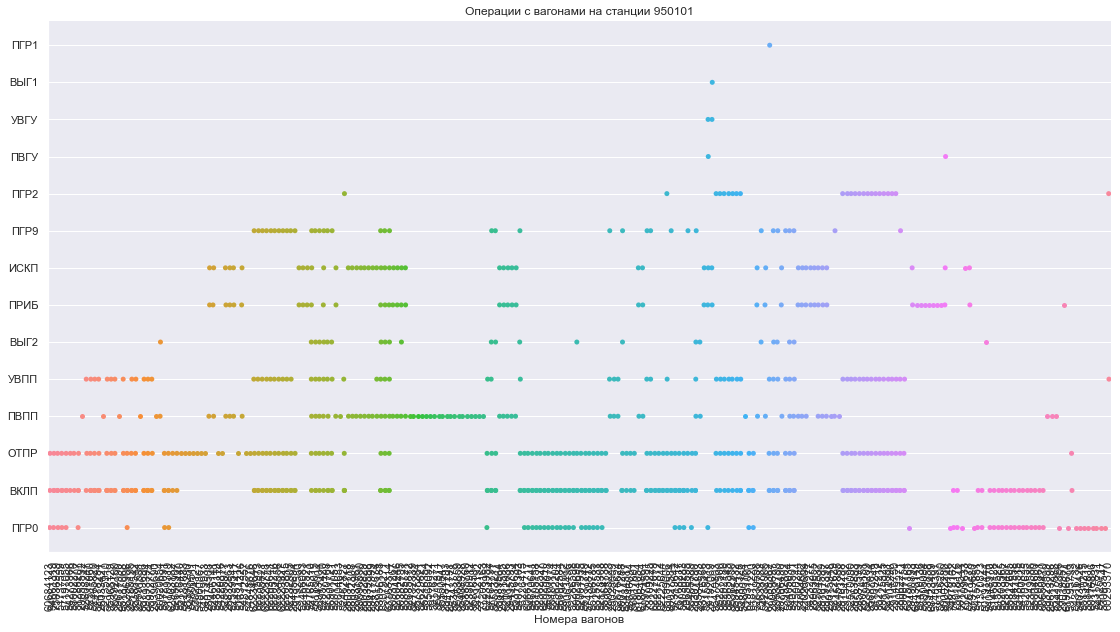

In [395]:
tmp_df = ndf[ndf.operation_st_esr == st_id].sort_values(by=['operation_date']).reset_index(drop=True)
tmp_df = tmp_df[['car_number','operation_car']]
tmp_df.car_number = tmp_df.car_number.apply(lambda x: str(x))
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])

if tmp_df.shape[0] > 800:
    print(f"Displaing first 800 operations out of {tmp_df.shape[0]}:")
    tmp_df = tmp_df.loc[:800]


sns.catplot(x=tmp_df['car_number'], y=tmp_df['operation_car'],data=tmp_df,height=8, aspect=4/2)
plt.ylabel('')
plt.xlabel('Номера вагонов')
plt.xticks(rotation=90)
# plt.minorticks_on()
plt.grid(which='minor')
plt.title(f'Операции с вагонами на станции {st_id}')
plt.show()
# del(tmp_df)

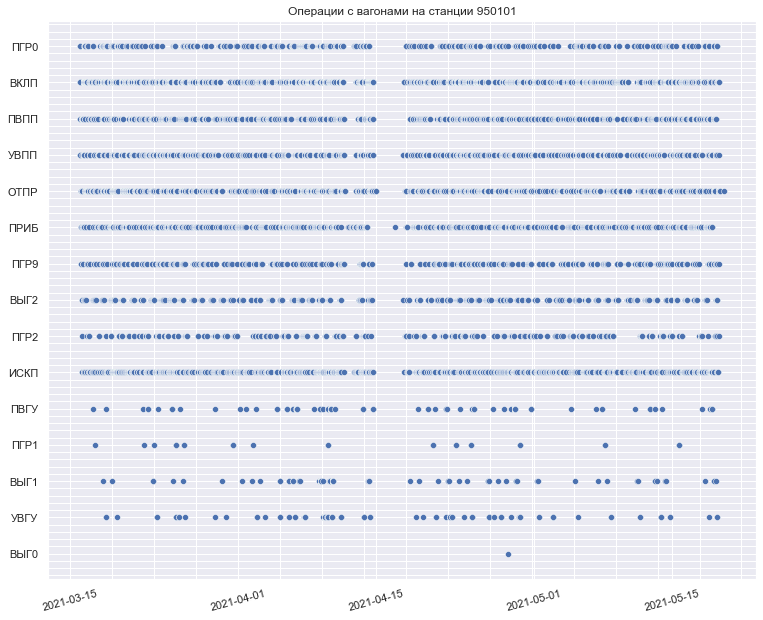

In [396]:
warnings.filterwarnings('ignore')

tmp_df = ndf[ndf.operation_st_esr == st_id].sort_values(by='operation_date').reset_index(drop=True)
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])
    
sns.scatterplot(x=tmp_df.operation_date.values,y=tmp_df.operation_car.values)
plt.xticks(rotation=15)
plt.title(f'Операции с вагонами на станции {st_id}')
plt.minorticks_on()
plt.grid(which='minor')
plt.show()
del(tmp_df)

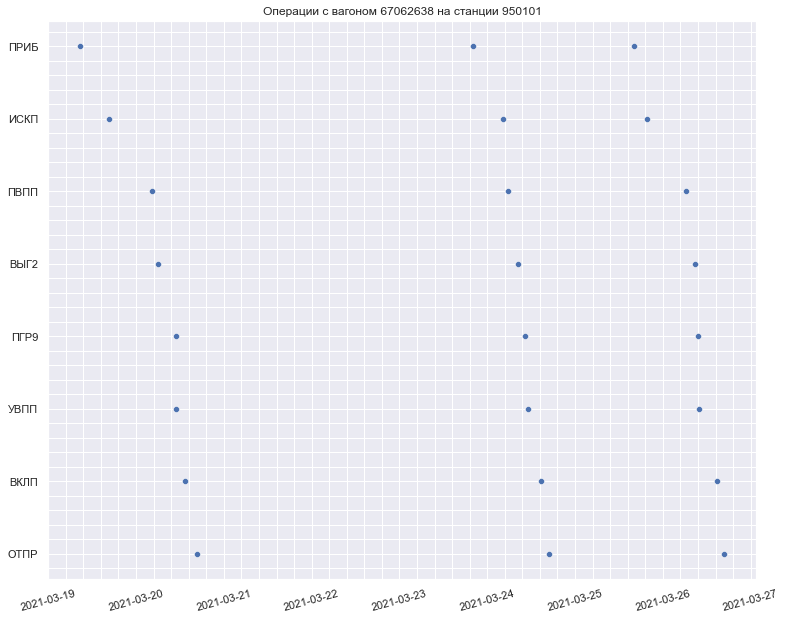

In [397]:
warnings.filterwarnings('ignore')
tmp_df = ndf[ndf.operation_st_esr == st_id][ndf.car_number == car_num].sort_values(by='operation_date').reset_index(drop=True)
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])

sns.scatterplot(x=tmp_df.operation_date.values,y=tmp_df.operation_car.values)
plt.xticks(rotation=15)
plt.title(f'Операции с вагоном {car_num} на станции {st_id}')
plt.minorticks_on()
plt.grid(which='minor')
plt.show()
del(tmp_df)

#### Отрисовка графов последовательностей операций

In [398]:
def ops_tr_for_set_of_carts(cartsSet: set) -> pd.DataFrame:
    """
    Builds DF with historical data of changes in states from one operation to another for a set of carts IDs.
    :param cartsSet: set with carts numbers from nom_vag_op
    :return: dataframe with following format (note that state changes are not unique)
        from 	to
    0 	3 	    4
    1 	4 	    3
    2 	3 	    4
    3 	4 	    3
    ...
    """
    stateChangeDF = pd.DataFrame(columns=['from', 'to'])

    for cartID in tqdm(cartsSet):
        opsListCart = list(ndf[ndf.car_number == cartID].sort_values(by=['operation_date'])['operation_car'])
        state_change = pd.DataFrame({'from': opsListCart[:-1], 'to': opsListCart[1:]})
        stateChangeDF = pd.concat(
            [stateChangeDF, state_change],
            axis=0,
            join="outer",
            ignore_index=True,
            keys=None,
            levels=None,
            names=None,
            verify_integrity=False,
            copy=True,
        )
    return stateChangeDF


def count_ops_transitions(cartsSet: set) -> dict:
    """
    Builds a dict with unique operation changes and state change frequency.
    :param cartsSet: set with carts numbers from nom_vag_op
    :return: dict with unique operations and their quantity. See example below:
    {'3->4': 2, '4->3': 2, '3->2': 1, '2->80': 1}
    """
    sChangeList = []
    linksDict: dict = {}
    sChangeDF = ops_tr_for_set_of_carts(cartsSet)
    for i in range(sChangeDF.shape[0]):
        src = str(list(sChangeDF.loc[i])[0])
        trg = str(list(sChangeDF.loc[i])[1])
        sChangeList.append(src + "->" + trg)
    for entry in sChangeList:
        key = str(entry)
        if key in linksDict.keys():
            linksDict[key] += 1
        else:
            linksDict[key] = 1
    return linksDict

In [415]:
set(ndf.car_number)

{54001664,
 62390273,
 51118081,
 60293123,
 60555265,
 62128129,
 61865986,
 55050249,
 62652425,
 60293131,
 54001680,
 62652433,
 63438865,
 51904530,
 52166675,
 50069525,
 52953114,
 60817434,
 50069533,
 57671711,
 54001698,
 68157478,
 56623143,
 63701031,
 54788138,
 52953130,
 54001706,
 62652458,
 57933871,
 61341749,
 57671737,
 64487481,
 62914619,
 52953148,
 62652482,
 63438915,
 60031044,
 53477444,
 54263884,
 63701072,
 62390356,
 43778133,
 54001755,
 62390364,
 62652508,
 60293214,
 68157536,
 94371937,
 57671778,
 62652516,
 52691045,
 73138281,
 60555372,
 62128236,
 62652524,
 60817517,
 63701106,
 63963250,
 61341814,
 57671802,
 56623226,
 63701114,
 29622396,
 50856061,
 59768960,
 57409666,
 64487556,
 44564615,
 98304140,
 60817558,
 67633305,
 63701148,
 62652573,
 52953247,
 94372000,
 58720418,
 62652581,
 52691110,
 54263975,
 52953262,
 62390448,
 43778224,
 57147571,
 52953270,
 57671869,
 61341889,
 94372034,
 62652615,
 62390471,
 50593995,
 68157650,

In [418]:
""" Примеры наборов номеров вагонов для отрисовки графов. """

# анализ по одному вагону
carSet = {car_num}

# aнализ по всем вагонам
# carSet = set(ndf.car_number)

# анализ по станциям stations
# option A - Показать все цепочки операций по станции
# carSet = set(ndf.car_number[ndf.operation_st_id == st_id])

# option B - выбрать только цепочки длиннее заданного числа
# st = ndf.car_number[ndf.operation_st_id == st_id].value_counts()
# carSet = set(st[st > 2].index)

#####################################

sdict = count_ops_transitions(carSet)

DG = Digraph('finite_state_machine', filename='ops_fsm')
DG.attr(rankdir='LR', size='8,5')

for key in sdict:
    src = car_ops[car_ops.index_code == float(key.split('->')[0])].values[0][1]
    dst = car_ops[car_ops.index_code == float(key.split('->')[1])].values[0][1]
    DG.edge(src, dst, weight=str(sdict[key]), label=str(sdict[key]))

DG.view()

100%|██████████| 1/1 [00:00<00:00, 24.77it/s]


'ops_fsm.pdf'

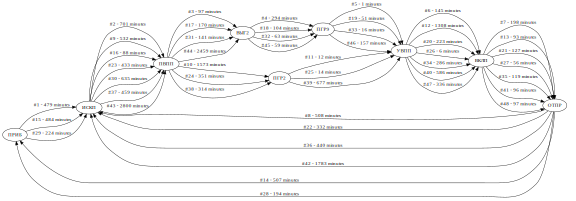

In [419]:
# построить граф переходов между операциями по вагону
# timedelta64[m] - в минутах
# timedelta64[h] - в часах

cops = ndf[ndf.car_number == car_num].sort_values(by=['operation_date'])['operation_car'].index
DG = Digraph(f'FSM for car #{car_num}', filename='ops_fsm_per_car')
DG.attr(rankdir='LR', size='8,5')

for i in range(1,len(cops)):
    src = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i-1]].values[0]].values[0]
    dst = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i]].values[0]].values[0]
    td = ndf.operation_date[ndf.index == cops[i]].values[0] - ndf.operation_date[ndf.index == cops[i-1]].values[0]
    td = str(td.astype('timedelta64[m]'))
    DG.edge(src, dst, label=f'#{str(i)} - {td}')


# DG.view() # выгрузить в pdf
DG # отобразить граф в ячейке

In [420]:
# cрез датасета по номеру вагона и выбранным полям
ndf[ndf.car_number == car_num].sort_values(by=['operation_date'])[['operation_car','operation_st_esr','destination_esr','ssp_station_esr','index_train']].reset_index(drop=True)

,operation_car,operation_st_esr,destination_esr,ssp_station_esr,index_train
0,8,950101,950101.00,950101.00,970001524950101.00
1,3,950101,950101.00,950101.00,970001524950101.00
2,80,950101,950101.00,NaN,NaN
3,21,950101,950101.00,NaN,NaN
4,19,950101,956305.00,NaN,NaN
5,81,950101,956305.00,NaN,NaN
6,4,950101,956305.00,956305.00,950101857956305.00
7,2,950101,956305.00,956305.00,950101857956305.00
8,3,956305,956305.00,956305.00,950101857956305.00
9,80,956305,956305.00,NaN,NaN


### Анализ цепочек операций

#### Выборка по станции. Словарь с последовательностями операций по вагонам

In [403]:
def extract_ops_chains(st_id: int) -> dict:
    '''
    Собирает цепочки операций по вагонам для заданной станции
    '''
    cars = {}
    for i in tqdm(ndf.car_number[ndf.operation_st_esr == st_id].unique()):
        cars[i] = str(ndf.operation_car[ndf.operation_st_esr == st_id][ndf.car_number == i].values)
        cars[i] = cars[i][1:-1].strip().replace('\n','')
    return cars

def sort_dict(dct: dict) -> dict:
    '''
    Сортирует цепочки операций
    '''
    return dict(sorted(dct.items(), key=lambda item: item[1], reverse=True))

In [404]:
cars_ops = sort_dict(extract_ops_chains(st_id))
cars_ops

100%|██████████| 2969/2969 [00:15<00:00, 193.91it/s]


{52657350: '81 80  3  8 80 81 11  4  4  2',
 30828016: '81 80',
 42146944: '81 80',
 43688530: '81 80',
 73106882: '81 21 19  4  4  2',
 60383916: '81 21  4  3 19 80  8  2',
 60587037: '81 21  4  3 19 80  8  2',
 60423167: '81 21  4  3 19 80  8  2',
 52760329: '81 19 21 80  3  8  4  2',
 52765427: '81 19 21 80  3  8',
 55131841: '81 19 21 80  3  4  2',
 60682804: '81 19 21 80  3  4  2',
 74997511: '81 19 21 80',
 54072228: '81 19 21  4  4  2',
 70722913: '81 19 21  4  4  2',
 90871781: '81 19 21  4',
 62234646: '81 19  4  4  2',
 62203641: '81 19  4  4  2',
 44226348: '81 19  2  4',
 54360870: '81 19',
 60293370: '81 11  4  4  2',
 29321197: '81 11  4  3  8 80 11 81  4  2',
 95945432: '81 11  4  2',
 52611514: '81 11  4  2',
 52662236: '81 11  2  4  4',
 29109295: '81 11  2  4',
 52633534: '81 11  2  4',
 29638699: '81 11',
 28212496: '81 11',
 67789362: '81 10  4  4  2',
 52765310: '81  4 80 21 19  2  3  8 19 81 80 21  2  4  2  8  3  4 80 19 21 81',
 56943004: '81  4 80 19 21  2  3  8

### Аггрегация вагонов по типовым последовательностям операций

In [334]:
def agg_by_car(dct: dict) -> dict:
    '''
    Аггрегирует номера вагонов по цепочкам операций
    '''
    res = {}
    for i, v in dct.items():
        res[v] = [i] if v not in res.keys() else res[v] + [i]
    return res

In [405]:
agg_by_car(cars_ops)

{'81 80  3  8 80 81 11  4  4  2': [52657350],
 '81 80': [30828016, 42146944, 43688530],
 '81 21 19  4  4  2': [73106882],
 '81 21  4  3 19 80  8  2': [60383916, 60587037, 60423167],
 '81 19 21 80  3  8  4  2': [52760329],
 '81 19 21 80  3  8': [52765427],
 '81 19 21 80  3  4  2': [55131841, 60682804],
 '81 19 21 80': [74997511],
 '81 19 21  4  4  2': [54072228, 70722913],
 '81 19 21  4': [90871781],
 '81 19  4  4  2': [62234646, 62203641],
 '81 19  2  4': [44226348],
 '81 19': [54360870],
 '81 11  4  4  2': [60293370],
 '81 11  4  3  8 80 11 81  4  2': [29321197],
 '81 11  4  2': [95945432, 52611514],
 '81 11  2  4  4': [52662236],
 '81 11  2  4': [29109295, 52633534],
 '81 11': [29638699, 28212496],
 '81 10  4  4  2': [67789362],
 '81  4 80 21 19  2  3  8 19 81 80 21  2  4  2  8  3  4 80 19 21 81': [52765310],
 '81  4 80 19 21  2  3  8 81  4 21 19 80  2  2  8 19 81  4  3 80 21': [56943004],
 '81  4 21 19  3 80  8  2': [64356652],
 '81  4 21 19  3 80  2  8': [56086358, 60665478],
 '81 

In [406]:
# подсчет цепочек операций совпадающих по вагонам
ocl = agg_by_car(cars_ops)
for key in ocl:
    ocl[key] = len(ocl[key])
ocl = sort_dict(ocl)
ocl

{'18  4  2': 140,
 '4 18  2': 86,
 '18  4  4  2': 69,
 '2 18  4': 59,
 '4': 58,
 '3 8': 46,
 '2  4 18': 37,
 '79  4  4  4  2': 29,
 '18  2  4': 25,
 '18  2  4  4': 24,
 '18  4': 23,
 '18': 23,
 '4  4 18  2': 22,
 '3  8 80': 22,
 '4 4 2': 21,
 '4 2': 19,
 '3 80  8': 18,
 '8  3 80': 16,
 '2 18  4  4': 16,
 '4 18  4  2': 14,
 '8 3': 13,
 '8  3 80 11 81  4  4  2': 13,
 '80  3  8': 12,
 '81': 11,
 '2  4 18  4': 11,
 '18  2  4  4  4  4': 11,
 '79': 10,
 '4 18': 10,
 '3  8 78 20 18 79  4  2': 10,
 '3  8 18  4  4  2': 10,
 '80': 9,
 '3 78 20  8 18': 9,
 '20 18  3 78  8  4 79  2': 9,
 '20  3 78  8 18': 9,
 '8  3 80 11 81  4  2': 8,
 '78 20  3  8 18': 8,
 '4  4 11 81  2': 8,
 '3  8 80 21 19 81  4  4  2': 8,
 '3  8 78 20 18  4 79  2': 8,
 '18  4  4  4  2': 8,
 '8  3 80  4  4 81 11  2': 7,
 '3  8 18 78 20 79  4  2': 7,
 '3  8 18  4  2': 7,
 '2 4': 7,
 '80  4  4 81 11  2': 6,
 '8 80  3': 6,
 '8  3 80 81  4 11  2': 6,
 '78 20  3  8': 6,
 '3  8 80 81': 6,
 '3  8 80 11 81  4  4  2': 6,
 '2 81 11  4  4

In [339]:
get_op_info(3)[0]

"По вагону: [3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']"

In [338]:
# цепочка операций для вагона car_num
# ops = list(ndf.operation_car[ndf.car_number == car_num].values)

ops = list(ocl.keys())[0]
ops = list(map(float, ops.split()))
print(f'Самая повторяющаяся цепочка операций на станции {st_id}:\n{ops}')

Самая повторяющаяся цепочка операций на станции 961604:
[3.0, 8.0]


In [340]:
# описание цепочки операций ops
for i in ops:
    print(car_ops[car_ops.index_code == i].values[0])

[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
[8 'ПРИБ' 'ПРИБЫТИЕ ВАГОНА НА СТАНЦИЮ            ']


### Формирование датасета

In [547]:
def build_df_for_train(df,ops):

    ## выбрать индексы нужных операций
    ops_index = pd.core.indexes.numeric.Int64Index([],dtype='int64')
    for op in ops:        
        ops_index = ops_index.append(df[df.operation_car == op].index)
    
    ## по индексам формируем словари с фичами
    ops_dict,times_dict,future_dict = dict.fromkeys(ops_index),dict.fromkeys(ops_index),dict.fromkeys(ops_index)
    for index in tqdm(ops_index):

        car_num = df.car_number[df.index == index].values[0]
        time_op = df.operation_date[df.index == index].values[0]

        temp_df = df[df.car_number == car_num].copy()
#         temp_df.operation_car = temp_df.operation_car.fillna(2)
        
        temp_df = temp_df.sort_values(by=['operation_date'])
        
        temp_df_future = temp_df[temp_df.operation_date > time_op]
        
        
        try:
            f1 = temp_df_future.operation_car.values[0]
            f2 = temp_df_future.operation_date.values[0] - time_op
            
        except:
            f1 = np.nan
            f2 = np.datetime64('')

        future = [f1,f2.astype('timedelta64[m]')]
        
        temp_df_past = temp_df[temp_df.operation_date <= time_op]
        temp_df_past = temp_df_past.drop(index,axis='index')

        times_list = time_op - temp_df_past.operation_date[-4:].iloc[::-1].values
        ops_list = temp_df_past.operation_car[-4:].iloc[::-1].values

        # to flip indexes .iloc[::-1]

        future_dict[index] = future
        times_dict[index] = times_list
        ops_dict[index] = ops_list
    
    ## конвертируем словари в pandas df
    df1 = pd.DataFrame.from_dict(times_dict,orient='index',columns=['minus1-time','minus2-time','minus3-time','minus4-time'])
    df2 = pd.DataFrame.from_dict(ops_dict,orient='index',columns=['minus1-op','minus2-op','minus3-op','minus4-op'])
    df3 = pd.DataFrame.from_dict(future_dict,orient='index',columns=['future_op','future_op_timedelta'])
    
    return pd.concat([df3,df.loc[ops_index],df2, df1], axis=1)

In [462]:
tst = ndf[ndf.operation_date < '2021-03-16 23:59:59']
tst = tst[tst.operation_date > '2021-03-15 23:59:59']

In [551]:
'''
21 ['ВЫГРУЗКА НА ПП                        ']
19 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']
11 ['ПОГРУЗКА НА ПП                        ']
18 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
20 ['ВЫГРУЗКА НА МЕСТАХ ОБЩ. ПОЛЬЗОВАНИЯ   ']
10 ['ПОГРУЗКА НА МЕСТАХ ОБЩ.ПОЛЬЗОВАНИЯ    ']
28 ['ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
29 ['ПРОЧИЕ, УЧИТЫВАЕМЫЕ КАК ВЫГРУЗКА      ']
'''
ops = [21, 19, 11, 18, 20, 10, 28, 29]

In [552]:
## посторить датасет zzz из датасета tst по списку операций ops
zzz = build_df_for_train(tst,ops)

100%|██████████| 5164/5164 [00:16<00:00, 315.92it/s]


In [553]:
zzz

,future_op,future_op_timedelta,adm,car_number,danger,destination_esr,destination_id,group_car,gruz,id,index_train,innovag,int_disl,kds,kod_group,length,loaded,lves,number_train,ont_time_write,operation_car,operation_date,operation_st_esr,operation_st_id,operation_train,operator,park,receiver,rodvag,rod_train,sender,ssp_station_esr,ssp_station_id,stkgos_id,tare_weight,track,train_id,uns,weight,weight_brutto,weight_netto,following_mark,processing_road,junction,special_mark_1,dispatch_id,minus1-op,minus2-op,minus3-op,minus4-op,minus1-time,minus2-time,minus3-time,minus4-time
581,NaN,NaT,20,42283358,NaN,968500.00,2002025541.00,0.00,81046.00,2320791581871,NaN,NaN,1,242,0.00,1.06,2,NaN,NaN,2021-03-17 09:05:16.449,21,2021-03-16 12:10:00,968406,2000038614,NaN,93294342,NaN,64396047.00,40,NaN,79299019.00,NaN,NaN,NaN,254,NaN,NaN,797686348,65154.00,NaN,NaN,0,96,NaN,0.00,2096ЭЦ410053,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
599,NaN,NaT,20,42294983,NaN,968500.00,2002025541.00,0.00,81188.00,2320791581924,NaN,NaN,1,242,4.00,1.06,2,NaN,NaN,2021-03-17 09:05:16.449,21,2021-03-16 07:22:00,968406,2000038614,NaN,93294342,NaN,84479829.00,40,NaN,63620784.00,NaN,NaN,NaN,262,NaN,NaN,797392417,51000.00,NaN,NaN,0,96,NaN,3.00,2096ЭЦ774224,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
662,81.00,0 days 00:13:00,20,50032473,1.00,967600.00,2000038600.00,0.00,226106.00,2320791583312,NaN,NaN,1,242,4.00,0.86,2,NaN,NaN,2021-03-17 09:05:17.908,21,2021-03-16 11:03:00,967600,2000038600,NaN,42876737,NaN,74568897.00,70,NaN,71211338.00,NaN,NaN,NaN,266,NaN,NaN,797616841,63326.00,NaN,NaN,0,96,NaN,4.00,207677958400,80.00,NaN,NaN,NaN,0 days 05:41:00,NaT,NaT,NaT
664,19.00,0 days 08:48:00,20,50033273,1.00,940006.00,2000037548.00,0.00,214043.00,2320791583333,NaN,NaN,1,242,0.00,0.86,2,NaN,NaN,2021-03-17 09:05:17.908,21,2021-03-16 10:00:00,940006,2000037548,NaN,95149153,NaN,57781649.00,70,NaN,48134187.00,NaN,NaN,NaN,263,NaN,NaN,797547200,59880.00,NaN,NaN,0,94,NaN,0.00,2088ЭЦ344077,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
667,19.00,0 days 14:00:00,20,50041797,NaN,944007.00,2000037796.00,0.00,161096.00,2320791583399,NaN,NaN,1,242,0.00,1.00,2,NaN,NaN,2021-03-17 09:05:17.908,21,2021-03-16 06:03:00,944007,2000037796,NaN,42767684,NaN,12627615.00,60,NaN,164517.00,NaN,NaN,NaN,238,NaN,NaN,797313135,69700.00,NaN,NaN,0,94,NaN,0.00,2094ЭЦ795307,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14685,79.00,0 days 11:10:00,20,98089048,NaN,946801.00,2000037862.00,0.00,391498.00,2320791782729,NaN,NaN,3,410,0.00,1.81,1,NaN,NaN,2021-03-17 09:06:09.464,10,2021-03-16 09:50:00,940006,2000037548,NaN,94421386,NaN,94421386.00,96,NaN,94421386.00,NaN,NaN,NaN,250,NaN,NaN,797527968,10430.00,NaN,NaN,0,94,NaN,0.00,2094ЭЦ901983,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
14768,79.00,0 days 04:54:00,20,98017833,NaN,940006.00,2000037548.00,0.00,391498.00,2320791782109,NaN,NaN,3,410,4.00,1.81,1,NaN,NaN,2021-03-17 09:06:09.92,10,2021-03-16 12:26:00,954704,2000038282,NaN,94421386,NaN,94421386.00,96,NaN,94421386.00,NaN,NaN,NaN,250,NaN,NaN,797703187,7900.00,NaN,NaN,0,94,NaN,3.00,2094ЭЦ914114,20.00,78.00,NaN,NaN,0 days 08:28:00,0 days 09:46:00,NaT,NaT
14770,79.00,0 days 15:28:00,20,98017924,NaN,937605.00,2000037508.00,0.00,391498.00,2320791782111,NaN,NaN,3,410,0.00,1.81,1,NaN,NaN,2021-03-17 09:06:09.92,10,2021-03-16 07:52:00,940006,2000037548,NaN,94421386,NaN,30473470.00,96,NaN,94421386.00,NaN,NaN,NaN,250,NaN,NaN,797413927,7780.00,NaN,NaN,0,94,NaN,0.00,2094ЭЦ899046,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
14788,79.00,0 days 01:03:00,20,96621594,NaN,989309.00,2000039132.00,0.00,81188.00,2320791781377,NaN,NaN,2,410,0.00,1.06,1,NaN,NaN,2021-03-17 09:06:09.92,10,2021-03-16 10:37:00,962109,2000038414,NaN,50875927,NaN,0.00,90,NaN,38682373.00,NaN,NaN,2000039132.00,255,NaN,NaN,797588756,69144.00,NaN,NaN,0,96,NaN,0.00,209630433679,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT


## Черновик:

### Профайлер

In [ ]:
## profiler code
# dt = datetime.datetime.now().strftime("%m/%d/%y - %H:%M")
# profile = ProfileReport(ndf, title=dt, explorative=True)
# fname = 'pd-report.html'
# profile.to_file(output_file=fname)